Data are generated from this script : https://www.kaggle.com/qnkhuat/make-data-ready

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime

from IPython.core.display import display,HTML
display(HTML("<style>.container{width:95% !important;}</style>"))
pd.options.display.max_columns = 999
#plt.rcParams['figure.figsize'] = (12,6)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from os.path import join as pjoin

data_root = 'input/make-data-ready'
print(os.listdir(data_root))

# Any results you write to the current directory are saved as output.

['results.zip', 'test_0.pkl', 'test_1.pkl', 'test_2.pkl', 'train_0.pkl', 'train_1.pkl', 'train_2.pkl', 'train_3.pkl', 'train_4.pkl', 'train_5.pkl', 'train_6.pkl', 'train_7.pkl', 'train_8.pkl']


# Import and load data

In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor as RFF
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,train_test_split, TimeSeriesSplit
from pprint import pprint
import math

from scipy.stats import kurtosis, skew


In [3]:

import seaborn as sns
import matplotlib.pyplot as plt
#import shap
plt.rcParams['figure.figsize'] = (12,6)

In [4]:
def load_data(data='train',n=2):
    df = pd.DataFrame()
    for i in range(n) :
        if data=='train':
            if i > 8 :
                break
            dfpart = pd.read_pickle(pjoin(data_root,f'train_{i}.pkl'))
        elif data=='test':
            if i > 2 :
                break
            dfpart = pd.read_pickle(pjoin(data_root,f'test_{i}.pkl'))
        df = pd.concat([df,dfpart])
        del dfpart
    return df
        

In [5]:
df_train = load_data(n=9)
df_test = load_data('test',n=4)

In [6]:
print(f'# of columns has na value: {(df_test.isnull().sum().sort_values(ascending=False) > 0).sum()}')

# of columns has na value: 0


# Base model

In [7]:
def rmse(y_true, y_pred):
    return round(np.sqrt(mean_squared_error(y_true, y_pred)), 5)

def split_data(df=df_train,rate=.8):
    # sort the date first
    df = df.sort_values('date').copy()
    
    df.drop(['fullVisitorId','visitId','visitStartTime'],axis=1,inplace=True)
    df['Revenue'] = np.log1p(df['Revenue'])
    
    global X_train,X_valid,y_train,y_valid
    
    n_train = int(len(df)*rate)
    X_train = df.drop(['Revenue','date'],axis=1).iloc[:n_train]
    X_valid = df.drop(['Revenue','date'],axis=1).iloc[n_train:]
    
    y_train = df['Revenue'].iloc[:n_train]
    y_valid = df['Revenue'].iloc[n_train:]
    
    print(X_train.shape,X_valid.shape)
    
    

def encode_data(verbose=False):
    global df_train_encoded,df_test_encoded
    df_train_encoded = df_train.copy()
    df_test_encoded = df_test.copy()
    for col in df_train.columns:
        if df_train_encoded[col].dtype == 'object' and col not in ['fullVisitorId','visitId','visitStartTime','date']:
            if verbose:
                print(col)
            lb = LabelEncoder()
            lb.fit( list(df_train_encoded[col].unique()) + list(df_test_encoded[col].unique()))
            df_train_encoded[col] = lb.transform(df_train_encoded[col])
            df_test_encoded[col] = lb.transform(df_test_encoded[col])
        
def run_xgb():
   
    params = {
        'objective':'reg:linear',
        'eval_metric':'rmse',
        'learning_rate':.01,
        'eta': 0.15, # Step size shrinkage used in update to prevents overfitting
#         'max_depth': 10, # V3 : 1.0471 on LB
#         'max_depth':5, # V5 : 0.9331 on LB
        'subsample': 0.6, # sample of rows
        'colsample_bytree': 0.6, # sample of features
#         'alpha':0.001, 
        'lambda':1, # l2 regu
        'random_state': 42,
        'silent':True
        
    }
    
    
    # got params from https://www.kaggle.com/kailex/group-xgb-for-gstore-v2
    params['n_thread'] = -1
    params['max_depth'] = 8
    params['min_child_weight'] = 100
    params['gamma'] = 5
    params['subsample'] = 1
    params['colsample_bytree'] = .95
    params['colsample_bylevel'] = 0.35
    params['alpha'] = 25
    params['lambda'] = 25
    
    xgb_train_data = xgb.DMatrix(X_train, y_train)
    xgb_val_data = xgb.DMatrix(X_valid, y_valid)
    
    model = xgb.train(params, xgb_train_data,
#           num_boost_round=1000, # V3 : 1.0471 on LB
#           num_boost_round=200, # 1.0471 on LB
          num_boost_round = 210,
          evals= [(xgb_train_data, 'train'), (xgb_val_data, 'valid')],
#           early_stopping_rounds=10, # V11 0.9301 on LB
          early_stopping_rounds=50, 
          verbose_eval=20
         )
    return model

def submit():
    test_matrix = xgb.DMatrix(X_test)
    y_pred = clf.predict(test_matrix,ntree_limit=clf.best_ntree_limit)
    df_test['PredictedLogRevenue'] = y_pred
    engineer_prediction
    print('rmse after engineer prediction')
    print(rmse(y_pred,df_test['PredictedLogRevenue']))
    submit = df_test[['PredictedLogRevenue','fullVisitorId']].groupby('fullVisitorId').PredictedLogRevenue.sum().reset_index()
    #submit.to_csv('submit.csv',index=False)
    return submit
    
    test(y_pred)
    
    
def engineer_prediction(df_test):
    df_test[df_test['totals_hits'] == 1].PredictedLogRevenue = 0
    df_test[df_test['totals_timeOnSite'] == 0].PredictedLogRevenue = 0
    df_test[df_test['totals_bouces'] == 1].PredictedLogRevenue = 0
    return dftest
    
    
def test(predict):
    y_test = np.log1p(df_test['totals_transactionRevenue'])
    print(rmse(y_test,predict))


In [8]:
def prepare_data(df_train,df_test,
                 del_col=['fullVisitorId','visitId','visitStartTime','date'],to_log=None):
    df_train = df_train.sort_values('date').copy()
    
    df_train = df_train.drop(del_col,axis=1).copy()
    df_test = df_test.drop(del_col,axis=1).copy()
    
    # Log some column
    if to_log is not None:
        df_train[to_log] = np.log1p(df_train[to_log])
        df_test[to_log] = np.log1p(df_test[to_log])
    
    # totals_transactionRevenue
    df_train['totals_transactionRevenue'] = np.log1p(df_train['totals_transactionRevenue'])
    df_test['totals_transactionRevenue'] = np.log1p(df_test['totals_transactionRevenue'])
    
    global X_train,X_valid,y_train,y_valid,X_test,y_test
    # 80/20 : train/valid
    n_train = int(len(df_train)*.8)
    
    # split
    X_train = df_train.drop(['totals_transactionRevenue'],axis=1).iloc[:n_train]
    X_valid = df_train.drop(['totals_transactionRevenue'],axis=1).iloc[n_train:]
    
    y_train = df_train['totals_transactionRevenue'].iloc[:n_train]
    y_valid = df_train['totals_transactionRevenue'].iloc[n_train:]
    
    X_test = df_test.drop(['totals_transactionRevenue'],axis=1)
    y_test = df_test['totals_transactionRevenue']
    
    

In [9]:
def feature_engineering(df):
    df = df.copy()
    # Copy from : https://www.kaggle.com/qnkhuat/base-model-v2-with-with-full-features/edit
    
    # time based
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday
    df['weekofyear'] = df['date'].dt.weekofyear
    
    df['browser_category'] = df['device_browser'] + '_' + df['device_deviceCategory']
    df['browser_operatingSystem'] = df['device_browser'] + '_' + df['device_operatingSystem']

    df['month_unique_user_count'] = df.groupby('month')['fullVisitorId'].transform('nunique')
    df['day_unique_user_count'] = df.groupby('day')['fullVisitorId'].transform('nunique')
    df['weekday_unique_user_count'] = df.groupby('weekday')['fullVisitorId'].transform('nunique')
    df['weekofyear_unique_user_count'] = df.groupby('weekofyear')['fullVisitorId'].transform('nunique')
    
    
    df['sum_pageviews_per_network_domain'] = df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('sum')
    df['count_pageviews_per_network_domain'] = df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('count')
    df['mean_pageviews_per_network_domain'] = df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('mean')
    df['sum_hits_per_network_domain'] = df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('sum')
    df['count_hits_per_network_domain'] = df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('count')
    df['mean_hits_per_network_domain'] = df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('mean')
    
    df['mean_hits_per_day'] = df.groupby(['day'])['totals_hits'].transform('mean')
    df['sum_hits_per_day'] = df.groupby(['day'])['totals_hits'].transform('sum')
    
    df['sum_pageviews_per_network_domain'] = df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('sum')
    df['count_pageviews_per_network_domain'] = df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('count')
    df['mean_pageviews_per_network_domain'] = df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('mean')

    df['sum_pageviews_per_region'] = df.groupby('geoNetwork_region')['totals_pageviews'].transform('sum')
    df['count_pageviews_per_region'] = df.groupby('geoNetwork_region')['totals_pageviews'].transform('count')
    df['mean_pageviews_per_region'] = df.groupby('geoNetwork_region')['totals_pageviews'].transform('mean')
    
    df['sum_hits_per_network_domain'] = df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('sum')
    df['count_hits_per_network_domain'] = df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('count')
    df['mean_hits_per_network_domain'] = df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('mean')

    df['sum_hits_per_region'] = df.groupby('geoNetwork_region')['totals_hits'].transform('sum')
    df['count_hits_per_region'] = df.groupby('geoNetwork_region')['totals_hits'].transform('count')
    df['mean_hits_per_region'] = df.groupby('geoNetwork_region')['totals_hits'].transform('mean')

    df['sum_hits_per_country'] = df.groupby('geoNetwork_country')['totals_hits'].transform('sum')
    df['count_hits_per_country'] = df.groupby('geoNetwork_country')['totals_hits'].transform('count')
    df['mean_hits_per_country'] = df.groupby('geoNetwork_country')['totals_hits'].transform('mean')
    
    df['user_pageviews_sum'] = df.groupby('fullVisitorId')['totals_pageviews'].transform('sum')
    df['user_hits_sum'] = df.groupby('fullVisitorId')['totals_hits'].transform('sum')
    
    df['user_pageviews_count'] = df.groupby('fullVisitorId')['totals_pageviews'].transform('count')
    df['user_hits_count'] = df.groupby('fullVisitorId')['totals_hits'].transform('count')

    
    df['user_pageviews_sum_to_mean'] = df['user_pageviews_sum'] / df['user_pageviews_sum'].mean()
    df['user_hits_sum_to_mean'] = df['user_hits_sum'] / df['user_hits_sum'].mean()

    df['user_pageviews_to_region'] = df['user_pageviews_sum'] / df['mean_pageviews_per_region']
    df['user_hits_to_region'] = df['user_hits_sum'] / df['mean_hits_per_region']
    
    return df

In [10]:
df_train = feature_engineering(df_train)
df_test = feature_engineering(df_test)

In [11]:
encode_data(verbose=True)
prepare_data(df_train_encoded,df_test_encoded,del_col=['fullVisitorId','visitId',
            'visitStartTime','date'],to_log=['visitNumber','totals_hits','totals_pageviews',
            'totals_sessionQualityDim','totals_timeOnSite','trafficSource_keyword'])
# prepare_data(df_train_encoded,df_test_encoded,del_col=['fullVisitorId','visitId',
#             'visitStartTime','date'])



channelGrouping
device_browser
device_deviceCategory
device_operatingSystem
geoNetwork_city
geoNetwork_continent
geoNetwork_country
geoNetwork_metro
geoNetwork_networkDomain
geoNetwork_region
geoNetwork_subContinent
trafficSource_adContent
trafficSource_adwordsClickInfo.adNetworkType
trafficSource_adwordsClickInfo.gclId
trafficSource_adwordsClickInfo.slot
trafficSource_campaign
trafficSource_keyword
trafficSource_medium
trafficSource_referralPath
trafficSource_source
customDimensions_value
browser_category
browser_operatingSystem


In [60]:
class TimeSeriasValidation():
    def __init__(self, data, n_splits=4):
        folds = TimeSeriesSplit(n_splits)
        ids = np.arange(data.shape[0])
        
        self.fold_ids = []
        for train_index, test_index in folds.split(data):
             self.fold_ids.append([train_index,test_index])
            
    def validate(self, train, test, features, model, name="", prepare_stacking=False, 
                 fit_params={"early_stopping_rounds": 25, "verbose": 100, "eval_metric": "rmse"}):
        model.FI = pd.DataFrame(index=features)
        full_score = 0
        
        if prepare_stacking:
            test[name] = 0
            train[name] = 0
        
        for fold_id, (trn, val) in enumerate(self.fold_ids):
            devel = train[features].iloc[trn]
            y_devel = y_train.iloc[trn]
            valid = train[features].iloc[val]
            y_valid = y_train.iloc[val]
                       
            print("Fold ", fold_id, ":")
            model.fit(devel, y_devel, eval_set=[(valid, y_valid)], **fit_params)
            
            if len(model.feature_importances_) == len(features):  # some bugs in catboost?
                model.FI['fold' + str(fold_id)] = model.feature_importances_ / model.feature_importances_.sum()

            predictions = model.predict(valid)
            predictions[predictions < 0] = 0
            print("Fold ", fold_id, " error: ", mean_squared_error(y_valid, predictions)**0.5)
            
            fold_score = mean_squared_error(y_valid, predictions)**0.5
            full_score += fold_score / len(self.fold_ids)
            print("Fold ", fold_id, " score: ", fold_score)
            
            if prepare_stacking: # and fold_id >2:
                
                train_predictions = model.predict(train[features])
                train_predictions[train_predictions < 0] = 0
                #train[name] += train_predictions / len(self.fold_ids)
                train[name] += train_predictions / (len(self.fold_ids))#/2)
                #print(train[name].mean())
                #train[name] += model.predict(train[features]) / len(self.fold_ids)  
                
                test_predictions = model.predict(test[features])
                test_predictions[test_predictions < 0] = 0
                #test[name] += test_predictions / len(self.fold_ids)
                test[name] += test_predictions / (len(self.fold_ids))#/2)
                
                
        print("Final score: ", full_score)
        return full_score

In [80]:
class TimeSeriasValidation():
    def __init__(self, data, n_splits=4):
        folds = TimeSeriesSplit(n_splits)
        ids = np.arange(data.shape[0])
        
        self.fold_ids = []
        for train_index, test_index in folds.split(data):
             self.fold_ids.append([train_index,test_index])
            
    def validate(self, train, test, features, model, name="", prepare_stacking=False, 
                 fit_params={"early_stopping_rounds": 25, "verbose": 100, "eval_metric": "rmse"}):
        model.FI = pd.DataFrame(index=features)
        full_score = 0
        
        if prepare_stacking:
            test[name] = 0
            train[name] = 0
        
        for fold_id, (trn, val) in enumerate(self.fold_ids):
            devel = train[features].iloc[trn]
            y_devel = y_train.iloc[trn]
            valid = train[features].iloc[val]
            y_valid = y_train.iloc[val]
                       
            print("Fold ", fold_id, ":")
            #model.fit(devel, y_devel, eval_set=[(valid, y_valid)], **fit_params)
            
            params = {'objective':'reg:linear','eval_metric':'rmse','learning_rate':.01, 'eta': 0.15, 'subsample': 0.6, 'colsample_bytree': 0.6, 'lambda':1, 'random_state': 42,'silent':True }
    
    
    # got params from https://www.kaggle.com/kailex/group-xgb-for-gstore-v2
            params['n_thread'] = -1
            params['max_depth'] = 8
            params['min_child_weight'] = 100
            params['gamma'] = 5
            params['subsample'] = 1
            params['colsample_bytree'] = .95
            params['colsample_bylevel'] = 0.35
            params['alpha'] = 25
            params['lambda'] = 25
    
            xgb_train_data = xgb.DMatrix(devel, y_devel)
            xgb_val_data = xgb.DMatrix(valid, y_valid)
    
            model = xgb.train(params, xgb_train_data,
        #           num_boost_round=1000, # V3 : 1.0471 on LB
        #           num_boost_round=200, # 1.0471 on LB
                  num_boost_round = 200,
                  evals= [(xgb_train_data, 'train'), (xgb_val_data, 'valid')],
        #           early_stopping_rounds=10, # V11 0.9301 on LB
                  early_stopping_rounds=25, 
                  verbose_eval=20)
            
            test_matrix = xgb.DMatrix(valid[features])
            
            predictions = model.predict(test_matrix,ntree_limit=clf.best_ntree_limit)
            predictions[predictions < 0] = 0
            print("Fold ", fold_id, " error: ", mean_squared_error(y_valid, predictions)**0.5)
            
            fold_score = mean_squared_error(y_valid, predictions)**0.5
            full_score += fold_score / len(self.fold_ids)
            print("Fold ", fold_id, " score: ", fold_score)
            
            if prepare_stacking: # and fold_id >2:
                
                pred_matrix = xgb.DMatrix(test[features])
                
                test_predictions = model.predict(pred_matrix,ntree_limit=clf.best_ntree_limit)
                test_predictions[test_predictions < 0] = 0
                test[name] += test_predictions / (len(self.fold_ids))#/2)
                
                
        print("Final score: ", full_score)
        return full_score

In [81]:
TimeSfolder = TimeSeriasValidation(X_train,4)

In [82]:
TimeSfolder.validate(X_train,X_test, X_train.columns, xgb, "lgbpred", prepare_stacking=True)

Fold  0 :
[0]	train-rmse:1.91166	valid-rmse:1.9421
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 25 rounds.
[20]	train-rmse:1.58466	valid-rmse:1.60861
[40]	train-rmse:1.30378	valid-rmse:1.32122
[60]	train-rmse:1.07533	valid-rmse:1.08739
[80]	train-rmse:0.888664	valid-rmse:0.896435
[100]	train-rmse:0.742174	valid-rmse:0.747041
[120]	train-rmse:0.617559	valid-rmse:0.61939
[140]	train-rmse:0.512917	valid-rmse:0.511787
[160]	train-rmse:0.430361	valid-rmse:0.427037
[180]	train-rmse:0.36346	valid-rmse:0.358545
[199]	train-rmse:0.310466	valid-rmse:0.3044
Fold  0  error:  0.3043999385157293
Fold  0  score:  0.3043999385157293
Fold  1 :
[0]	train-rmse:1.92694	valid-rmse:2.10888
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 25 rounds.
[20]	train-rmse:1.59181	valid-rmse:1.74264
[40]	train-rmse:1.31591	valid-rmse:1.44108
[60

0.2831106910857255

In [ ]:
#0.2831106910857255 200 n_roounds
#0.2591649420889318 500 n_roounds 0.42998 on pred

In [79]:
test(X_test.lgbpred)
df_test['PredictedLogRevenue'] = X_test.lgbpred
engineer_prediction
#print('rmse after engineer prediction')
#print(rmse(X_test.lgbpred,df_test['PredictedLogRevenue']))
submit = df_test[['PredictedLogRevenue','fullVisitorId']].groupby('fullVisitorId').PredictedLogRevenue.sum().reset_index()
submit.to_csv('submit_xgb_TScv.csv',index=False)

0.42998


In [67]:
import lightgbm as lgb

In [62]:
TimeSfolder = TimeSeriasValidation(X_train,4)

In [63]:
lgbmodel = lgb.LGBMRegressor(n_estimators=800, objective="regression", metric="rmse", num_leaves=13, min_child_samples=75,
                      learning_rate=0.15, bagging_fraction=0.75, feature_fraction=0.55, bagging_frequency=6, 
                      bagging_seed=12345, subsample=.9, colsample_bytree=.9, use_best_model=True)
#catmodel = cat.CatBoostRegressor(iterations=500, learning_rate=0.2, depth=5, random_seed=2019)

In [64]:
TimeSfolder.validate(X_train,X_test, X_train.columns, lgbmodel, "lgbpred", prepare_stacking=True)

Fold  0 :
Training until validation scores don't improve for 25 rounds.
[100]	valid_0's rmse: 0.0399706
[200]	valid_0's rmse: 0.0379461
[300]	valid_0's rmse: 0.0362119
[400]	valid_0's rmse: 0.0348558
Early stopping, best iteration is:
[447]	valid_0's rmse: 0.0343275
Fold  0  error:  0.03297419050478618
Fold  0  score:  0.03297419050478618
Fold  1 :
Training until validation scores don't improve for 25 rounds.
[100]	valid_0's rmse: 0.0322721
[200]	valid_0's rmse: 0.0295117
[300]	valid_0's rmse: 0.028561
[400]	valid_0's rmse: 0.0281268
[500]	valid_0's rmse: 0.0279178
[600]	valid_0's rmse: 0.027535
Early stopping, best iteration is:
[654]	valid_0's rmse: 0.027432
Fold  1  error:  0.027119589500652328
Fold  1  score:  0.027119589500652328
Fold  2 :
Training until validation scores don't improve for 25 rounds.
[100]	valid_0's rmse: 0.0283652
[200]	valid_0's rmse: 0.0263678
[300]	valid_0's rmse: 0.0253879
Early stopping, best iteration is:
[301]	valid_0's rmse: 0.0253838
Fold  2  error:  0.0

0.025643752406626863

In [ ]:
#0.029667376323395535
#0.026575249785645644 - new param
#0.025643752406626863 - + new valid

In [65]:
test(X_test.lgbpred)
df_test['PredictedLogRevenue'] = X_test.lgbpred
engineer_prediction
#print('rmse after engineer prediction')
#print(rmse(X_test.lgbpred,df_test['PredictedLogRevenue']))
submit = df_test[['PredictedLogRevenue','fullVisitorId']].groupby('fullVisitorId').PredictedLogRevenue.sum().reset_index()
submit.to_csv('submit_lgbm_TScv2.csv',index=False)

0.14819


In [35]:
features = X_train.columns[:-1]

In [47]:
paramsl = {'n_estimators':[200], 
          'objective':["regression"], 'metric':["rmse"], 
          'num_leaves':[12,13,14], 
          'min_child_samples':[73,75,77],
          'learning_rate':[0.13,0.15,0.17], 
          'bagging_fraction':[0.75], 
          'feature_fraction':[0.55],
          'bagging_frequency':[6], 
          'bagging_seed':[12345], 
          'subsample':[.9], 
          'colsample_bytree':[.9], 
          'use_best_model':[True]
}

xgbmodel = xgb.XGBRegressor(n_jobs=20)
lgbmodel = lgb.LGBMRegressor(n_jobs=20)

gs = GridSearchCV(lgbmodel,
                  param_grid=paramsl,
                  cv=TimeSeriesSplit(3),
#                      scoring="neg_mean_squared_error",
                  n_jobs=20,
                  verbose=1)
gs.fit(X_train[features], y_train)
y_pred = gs.predict(X_valid[features])
rmse(y_valid,y_pred)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:  3.5min
[Parallel(n_jobs=20)]: Done  81 out of  81 | elapsed: 20.6min finished


0.03438

In [46]:
gs.best_params_ #0.02918

{'bagging_fraction': 0.75,
 'bagging_frequency': 6,
 'bagging_seed': 12345,
 'colsample_bytree': 0.9,
 'feature_fraction': 0.55,
 'learning_rate': 0.15,
 'metric': 'rmse',
 'min_child_samples': 75,
 'n_estimators': 200,
 'num_leaves': 13,
 'objective': 'regression',
 'subsample': 0.9,
 'use_best_model': True}

In [44]:
gs.best_params_ #0.03054

{'bagging_fraction': 0.75,
 'bagging_frequency': 6,
 'bagging_seed': 12345,
 'colsample_bytree': 0.9,
 'feature_fraction': 0.55,
 'learning_rate': 0.15,
 'metric': 'rmse',
 'min_child_samples': 75,
 'n_estimators': 200,
 'num_leaves': 10,
 'objective': 'regression',
 'subsample': 0.9,
 'use_best_model': True}

In [42]:
#gs.best_params_ #0.03495

{'bagging_fraction': 0.75,
 'bagging_frequency': 6,
 'bagging_seed': 12345,
 'colsample_bytree': 0.9,
 'feature_fraction': 0.55,
 'learning_rate': 0.1,
 'metric': 'rmse',
 'min_child_samples': 80,
 'n_estimators': 200,
 'num_leaves': 15,
 'objective': 'regression',
 'subsample': 0.9,
 'use_best_model': True}

In [40]:
# gs.best_params_ # 0.03624

{'bagging_fraction': 0.75,
 'bagging_frequency': 6,
 'bagging_seed': 12345,
 'colsample_bytree': 0.9,
 'feature_fraction': 0.55,
 'learning_rate': 0.1,
 'metric': 'rmse',
 'min_child_samples': 80,
 'n_estimators': 200,
 'num_leaves': 25,
 'objective': 'regression',
 'subsample': 0.9,
 'use_best_model': True}

In [12]:
%%time
clf = run_xgb()

[0]	train-rmse:1.89939	valid-rmse:1.64273
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[20]	train-rmse:1.55805	valid-rmse:1.34882
[40]	train-rmse:1.28673	valid-rmse:1.11512
[60]	train-rmse:1.06259	valid-rmse:0.921494
[80]	train-rmse:0.87307	valid-rmse:0.758732
[100]	train-rmse:0.722905	valid-rmse:0.62962
[120]	train-rmse:0.603277	valid-rmse:0.52672
[140]	train-rmse:0.497445	valid-rmse:0.435266
[160]	train-rmse:0.412016	valid-rmse:0.362226
[180]	train-rmse:0.34123	valid-rmse:0.301048
[200]	train-rmse:0.284056	valid-rmse:0.251608
[209]	train-rmse:0.261986	valid-rmse:0.232599
Wall time: 6min 35s


In [ ]:
#[199]	train-rmse:0.286631	valid-rmse:0.253844
#lb 0.9748

# early_stopping_rounds=10 - 2000 итераций
# [1311]	train-rmse:0.035747	valid-rmse:0.034632
# lb  1.1325

# early_stopping_rounds=50 - 400 итераций
#[399]	train-rmse:0.068595	valid-rmse:0.06478
# lb 1.1121,        

#[209]	train-rmse:0.261986	valid-rmse:0.232599

#LGBM+TScv lb 1.1123 and 0.34796 local

# try to find a good validation set
# Why our score so different with the leader board?
# check with the target in dataset first

In [ ]:
    params = {
        'objective':['reg:linear'],
#        'eval_metric':['rmse'],
        'learning_rate': [.01,.1],
        'n_estimators' : [100],
#        'eta': [0.10,0.15,0.20], # Step size shrinkage used in update to prevents overfitting
#         'max_depth': 10, # V3 : 1.0471 on LB
         'max_depth': [6,8,10], # V5 : 0.9331 on LB
        'subsample': [0.5,0.6,0.7,1], # sample of rows
        'colsample_bytree': [0.5,0.6,0.7,0.95], # sample of features
        'colsample_bylevel' :[ 0.35],
 #        'alpha':[0.001,25], 
 #       'lambda':[1,25], # l2 regu
        'min_child_weight' : [100],
        'random_state': [42],
        'silent':[True]
        
    }
    

    #xgb_train_data = xgb.DMatrix(X_train, y_train)
    #xgb_val_data = xgb.DMatrix(X_valid, y_valid)

    
    xgbmodel = xgb.XGBRegressor(n_jobs=32)
    
    
    gs = GridSearchCV(xgbmodel,
                      param_grid=params,
                      cv=3,#TimeSeriesSplit(3),
#                      scoring="neg_mean_squared_error",
                      n_jobs=32,
                      verbose=1)
#    gs.fit(X_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


In [57]:
y_pred = gs.predict(X_valid)
rmse(y_valid,y_pred)

0.35703

In [51]:
xgbmodel.get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample'])

# Feature important

"gain" is the average gain of splits which use the feature

Text(0.5,1,'Gain Feature important')

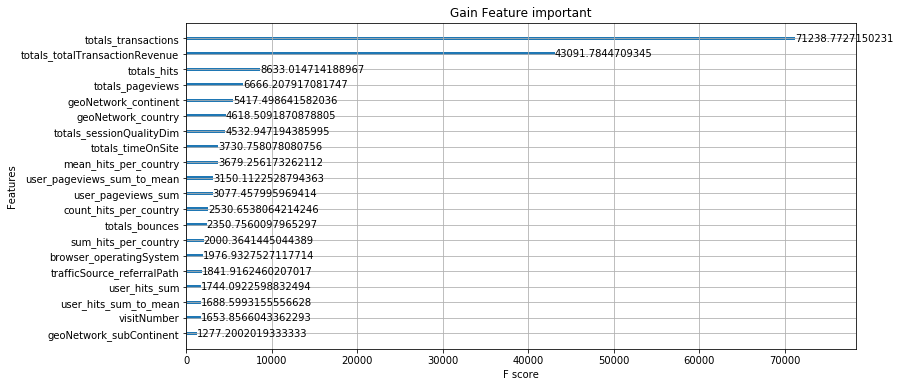

In [22]:
xgb.plot_importance(clf,importance_type='gain',max_num_features=20)
plt.title('Gain Feature important')

"cover" is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split

Text(0.5,1,'Cover Feature important')

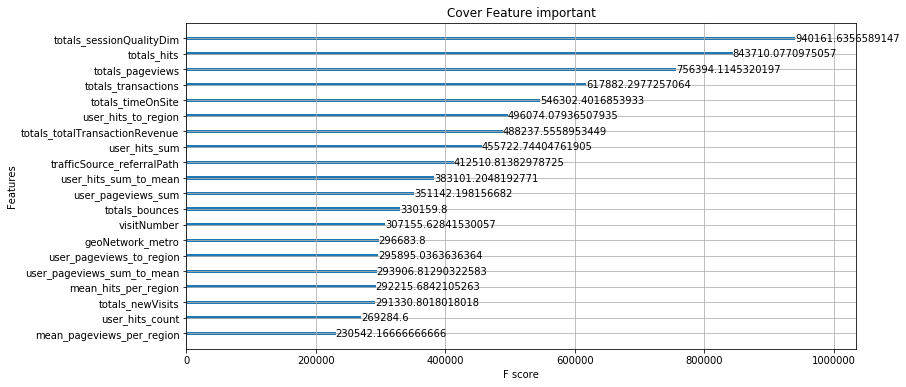

In [23]:
xgb.plot_importance(clf,importance_type='cover',max_num_features=20)
plt.title('Cover Feature important')

"weight" is the number of times a feature appears in a tree

Text(0.5,1,'Weight Feature important')

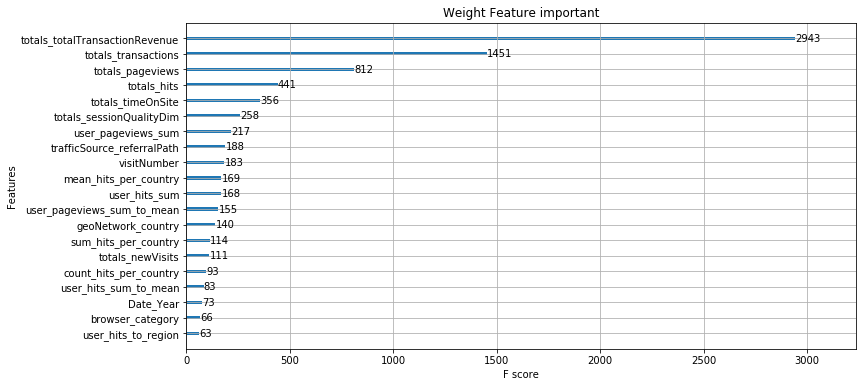

In [24]:
xgb.plot_importance(clf,importance_type='weight',max_num_features=20)
plt.title('Weight Feature important')

# Submit

In [36]:
submission = submit()
submission['PredictedLogRevenue'] = submission['PredictedLogRevenue'].apply(lambda x: 0 if x < 0 else x)
submission.to_csv('submit4.csv',index=False)

rmse after engineer prediction
0.0


In [37]:
#submission['PredictedLogRevenue'] = submission['PredictedLogRevenue'].apply(lambda x: 0 if x < 0 else x)   #[submission['PredictedLogRevenue']<0]['PredictedLogRevenue'] = 0
submission.head(10)

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.008794
1,0000039738481224681,0.008761
2,0000073585230191399,0.008761
3,0000087588448856385,0.008761
4,0000149787903119437,0.008761
5,0000196310838896290,0.051778
6,00001995526696366,0.008761
7,0000255704530917106,0.000000
8,0000268499301061358,0.008816
9,0000276747989270229,0.008761


In [ ]:
os.listdir()